## Evalute models

In [1]:
using Flux
using Flux: onehotbatch, onecold, crossentropy
using Plots
using BSON
using StatsBase: mean, counts, sample, median

using Images: Gray
using DataFrames
using Printf

In [2]:
include("DigitDetection/ml_utils.jl");

## Load data

In [5]:
@time data, labels = load_data("../../datasets/74k_numbers_28x28/");

loading data from ../../datasets/74k_numbers_28x28/0
loading data from ../../datasets/74k_numbers_28x28/1
loading data from ../../datasets/74k_numbers_28x28/2
loading data from ../../datasets/74k_numbers_28x28/3
loading data from ../../datasets/74k_numbers_28x28/4
loading data from ../../datasets/74k_numbers_28x28/5
loading data from ../../datasets/74k_numbers_28x28/6
loading data from ../../datasets/74k_numbers_28x28/7
loading data from ../../datasets/74k_numbers_28x28/8
loading data from ../../datasets/74k_numbers_28x28/9
  2.929317 seconds (976.88 k allocations: 106.069 MiB, 2.36% gc time)


In [6]:
seed = 227
rng = MersenneTwister(seed)
x_train, y_train, x_test, y_test = split_data(data, labels, rng=rng);
y_train = onehotbatch(y_train, 0:9)
y_test =  onehotbatch(y_test, 0:9);
x_train = Flux.batch(x_train)
x_test = Flux.batch(x_test)
;

## Explore data

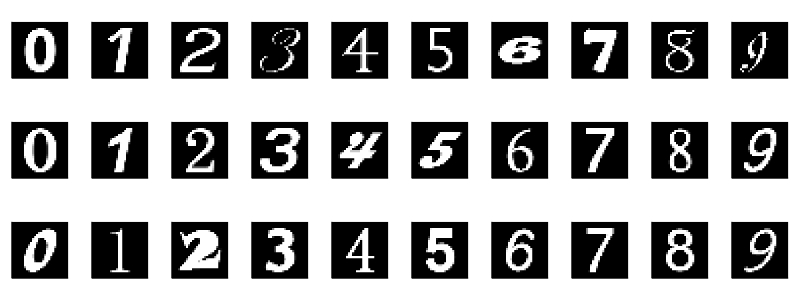

In [7]:
canvases = []
n_rows = 3

idxs_to_plot = zeros(Int, (n_rows, 10))
# collect data by columns
for j in 0:9
    valid_idxs = collect(1:length(labels))[labels .== j]
    for (i, idx) in enumerate(sample(valid_idxs, n_rows, replace=false))
        idxs_to_plot[i, j + 1] = idx
    end
end
# enter data into canvases by row
for i in 1:n_rows
    for j in 0:9
        idx = idxs_to_plot[i, j + 1]
        canvas = plot(Gray.(data[idx][:, :]))
        push!(canvases, canvas)
    end
end
plot(canvases..., layout=(n_rows, 10), ticks=nothing, border=nothing,  size=(800, 300))

$$
\begin{align}
\bar{x}_n &= \frac{1}{n}\sum_i^n x_i \\
        &= \frac{\bar{x}_{n-1}(n - 1) + x_n}{n} \\
\end{align}
$$

In [8]:
function moving_average(x::AbstractArray)
    n = 0
    x̄ = zero(first(x))
    for x_i in x
       x̄ = (x̄ * n + x_i)/(n + 1)
       n += 1
    end
    x̄
end

moving_average (generic function with 1 method)

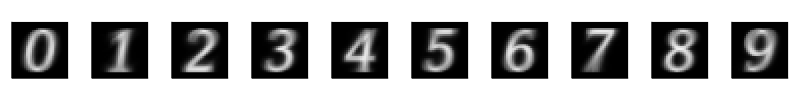

In [9]:
mean_images = []
canvases = []
for j in 0:9
    mean_img = moving_average(data[labels .== j])
    push!(mean_images, mean_img)
    canvas = plot(Gray.(mean_img[:, :, 1]))
    push!(canvases, canvas)
end
plot(canvases..., layout=(1, 10), ticks=nothing, border=nothing,  size=(800, 100))

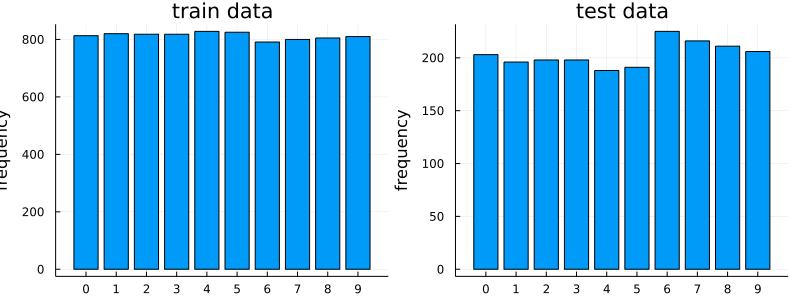

In [10]:
canvas_test = bar(
    0:9, counts(onecold(y_test, 0:9)), 
    label="", 
    xticks=0:9,
    ylabel="frequency",
    title="test data"
)
canvas_train = bar(
    0:9, counts(onecold(y_train, 0:9)), 
    label="", 
    xticks=0:9,
    ylabel="frequency",
    title="train data"
)

plot(canvas_train, canvas_test, layout = (1, 2), size=(800, 300))

## Load model

Models: 
- cnn_dropout.bson
- cnn_dropout_small.bson
- cnn_Flux.bson
- LeNet5.bson
- nn_simple.bson

In [11]:
model_path = joinpath("DigitDetection\\models", "LeNet5" * ".bson")

"DigitDetection\\models\\LeNet5.bson"

In [12]:
BSON.@load model_path model history
model

Chain(
  Conv((5, 5), 1 => 6, relu),           # 156 parameters
  MaxPool((2, 2)),
  Conv((5, 5), 6 => 16, relu),          # 2_416 parameters
  MaxPool((2, 2)),
  Flux.flatten,
  Dense(256, 120, relu),                # 30_840 parameters
  Dense(120, 84, relu),                 # 10_164 parameters
  Dense(84, 10),                        # 850 parameters
)                   # Total: 10 arrays, 44_426 parameters, 174.867 KiB.

Compile model

In [13]:
model(x_train[:, :, :, 1:10]); 

## Evaluate

Accuracy

In [14]:
accuracy(ŷ, y) = mean(onecold(ŷ, 0:9) .== onecold(y, 0:9))
accuracy(model(x_train[:, :, :, 1:10]), y_train[:, 1:10]) ;

In [15]:
@time train_accuracy = accuracy(model(x_train), y_train)
@printf "train accuracy for %d samples: %.4f\n" size(x_train, 4) train_accuracy

ŷ = model(x_test)
@time test_accuracy = accuracy(ŷ, y_test)
@printf " test accuracy for %d samples: %.4f" size(x_test, 4) test_accuracy

  0.588340 seconds (219 allocations: 326.197 MiB, 8.89% gc time)
train accuracy for 8128 samples: 0.9951
  0.000175 seconds (14 allocations: 76.578 KiB)
 test accuracy for 2032 samples: 0.9867

Wrong values

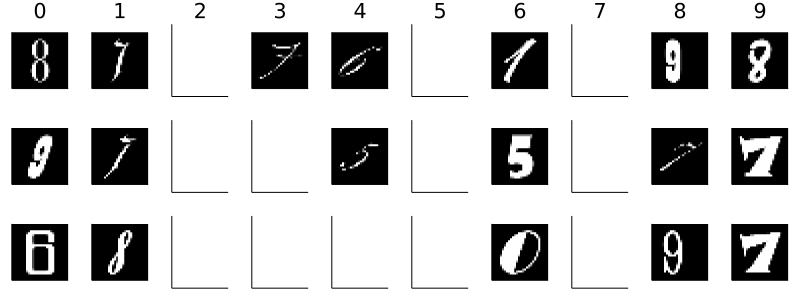

In [16]:
n_test = size(x_test, 4)
ŷ = model(x_test)
canvases = []
n_rows = 3

wrong_idxs = collect(1:n_test)[onecold(ŷ, 0:9) .!= onecold(y_test, 0:9)];

idxs_to_plot = zeros(Int, (n_rows, 10))
# collect data by columns
for j in 0:9
    j_idxs = wrong_idxs[onecold(ŷ[:, wrong_idxs], 0:9) .== j]
    sample_idxs = length(j_idxs) > n_rows ? sample(j_idxs, n_rows, replace=false) : j_idxs
    for (i, idx) in enumerate(sample_idxs)
        idxs_to_plot[i, j + 1] = idx
    end
end
# enter data into canvases by row
for i in 1:n_rows
    for j in 0:9
        idx = idxs_to_plot[i, j + 1]
        canvas = idx == 0 ? plot() : plot(Gray.(x_test[:, :, 1, idx]))
        if i == 1 
            plot!(canvas, title=string(j))
        end
        push!(canvases, canvas)
    end
end
plot(canvases..., layout=(n_rows, 10), ticks=nothing, border=nothing,  size=(800, 300))

self-knowledge

In [17]:
ŷ = model(x_test)
probs = maximum(softmax(ŷ), dims=1)
outcome = onecold(ŷ, 0:9) .== onecold(y_test, 0:9);

In [18]:
canvas = plot()
wrong = (outcome .== 0)
histogram!(canvas, probs[wrong], color=:red, label="wrong")
q2 = median(probs[wrong])
@printf "median wrong probability: %.4f\n" q2*100

correct = (outcome .== 1)
histogram!(canvas, probs[correct], color=:green, label="correct")
q2 = median(probs[correct])
@printf "median correct probability: %.4f" q2*100

canvas

median wrong probability: 66.2556
median correct probability: 99.9987

Inference time

In [19]:
elapsed_time = time_ns()
model(x_train)
elapsed_time = time_ns() - elapsed_time

n = size(x_train, 4)
@printf "time per prediction: %.4f ms" (elapsed_time/1e6/n)

time per prediction: 0.0625 ms

## Compare models

In [20]:
df_models = DataFrame(
    name=["cnn_Flux", "LeNet5", "cnn_dropout", "cnn_dropout_small", "nn_simple", "cnn_mastery", "cnn_huge"], 
    train_accuracy=[0.9964, 0.9951, 0.9937, 0.9862, 0.9843, 0.9999, 0.9926],
    test_accuracy=[0.9862, 0.9867, 0.9867, 0.9774, 0.9675, 0.9877, 0.9813],
    inference_time=[0.2885, 0.0806, 0.1355, 0.0576, 0.0023, 0.1547, 0.8164], #ms
    file_size=[101, 183, 79.4, 27.7, 103, 2.07*1024, 4.58*1024],
    parameters=[16_938, 44_426, 18_378, 5_142, 25_450, 542_230, 1_199_882]
)
;

In [21]:
sort!(df_models, [order(:test_accuracy, rev=true), order(:inference_time)])

,name,train_accuracy,test_accuracy,inference_time,file_size,parameters
,String,Float64,Float64,Float64,Float64,Int64
1,cnn_mastery,0.9999,0.9877,0.1547,2119.68,542230
2,LeNet5,0.9951,0.9867,0.0806,183.0,44426
3,cnn_dropout,0.9937,0.9867,0.1355,79.4,18378
4,cnn_Flux,0.9964,0.9862,0.2885,101.0,16938
5,cnn_huge,0.9926,0.9813,0.8164,4689.92,1199882
6,cnn_dropout_small,0.9862,0.9774,0.0576,27.7,5142
7,nn_simple,0.9843,0.9675,0.0023,103.0,25450
